# 0. Library

In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import time
import pickle
import os
import torch

# --- Sklearn ---
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict # Added cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve, auc,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, brier_score_loss, log_loss, classification_report)
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.ensemble import StackingClassifier
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold # Added for feature selection

# --- Imbalanced Learn ---
from imblearn.pipeline import Pipeline as ImblearnPipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

# --- Model Specific Libraries ---
import xgboost as xgb
import lightgbm as lgb

# --- WOE/Scorecard Library ---
# import scorecardpy as sc # For LR+WOE variant (Keep commented if not using)

# --- Bayesian Optimization ---
import optuna # Added Optuna

# --- Display Options ---
# Set display options (optional but helpful)
pd.set_option('display.max_columns', None) # Show all columns
pd.set_option('display.max_rows', 100)    # Show more rows
pd.set_option('display.float_format', lambda x: '%.5f' % x) # Format floats
warnings.filterwarnings('ignore', category=FutureWarning) # Ignore specific warnings if needed
warnings.filterwarnings('ignore', category=UserWarning)

c:\Users\ORLab\main_source\CreditRiskProject\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Utility Function + Configuration

## 1.1 Helper Function

In [2]:
# --- Helper Functions ---
def calculate_ks(y_true, y_prob):
    """Calculates the Kolmogorov-Smirnov (KS) statistic."""
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values(by='y_prob', ascending=False)
    df['cumulative_true'] = df['y_true'].cumsum() / df['y_true'].sum()
    df['cumulative_false'] = (1 - df['y_true']).cumsum() / (1 - df['y_true']).sum()
    ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
    return ks

def find_optimal_threshold_j_statistic(y_true, y_prob_oof):
    """Finds the optimal threshold maximizing Youden's J statistic (Sensitivity + Specificity - 1)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob_oof)
    j_statistic = tpr - fpr
    optimal_idx = np.argmax(j_statistic)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold based on Youden's J-Statistic (OOF): {optimal_threshold:.4f}")
    return optimal_threshold

def evaluate_model(y_true, y_pred_proba, y_pred_binary, model_name="Model"):
    """Calculates and prints standard classification metrics."""
    auc_roc = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * auc_roc - 1
    ks = calculate_ks(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    brier = brier_score_loss(y_true, y_pred_proba)
    logloss = log_loss(y_true, y_pred_proba)
    cm = confusion_matrix(y_true, y_pred_binary)

    print(f"\n--- Evaluation Metrics for {model_name} ---")
    print(f"AUC ROC:        {auc_roc:.4f}")
    print(f"Gini Coefficient: {gini:.4f}")
    print(f"KS Statistic:   {ks:.4f}")
    print(f"Accuracy:       {accuracy:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall (TPR):   {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"Brier Score:    {brier:.4f}")
    print(f"Log Loss:       {logloss:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    # print("\nClassification Report:")
    # print(classification_report(y_true, y_pred_binary))

    results = {
        'Model': model_name,
        'AUC': auc_roc,
        'Gini': gini,
        'KS': ks,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Brier': brier,
        'LogLoss': logloss
    }
    return results

def plot_roc_curve(y_true, y_prob, model_name):
    """Plots the ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_roc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_roc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

def get_feature_importance(model, feature_names, top_n=50):
    """Extracts and displays feature importances."""
    print(f"\n--- Top {top_n} Feature Importances ---")
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            # For linear models, use absolute coefficient values
            importances = np.abs(model.coef_[0]) # Assuming binary classification coef_[0]
        else:
            print("Model does not have standard feature_importances_ or coef_ attribute.")
            return None

        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

        # Check if importance sum is close to 1 (typical for tree models)
        print(f"Sum of importances: {feature_importance_df['importance'].sum():.4f}")

        display(feature_importance_df.head(top_n))
        return feature_importance_df

    except Exception as e:
        print(f"Could not get feature importances: {e}")
        return None


## 1.2 Early Stopping

In [3]:
# Define custom early stopping callbacks for Optuna
class EarlyStoppingCallback:
    def __init__(self, patience=5, min_improvement=0.001):
        self.patience = patience
        self.min_improvement = min_improvement
        self.best_score = None
        self.no_improvement_count = 0
        self.trial_history = []
        print(f"EarlyStoppingCallback initialized: patience={patience}, min_improvement={min_improvement}")
        
    def __call__(self, study, trial):
        current_score = trial.value
        trial_number = trial.number
        
        # Skip if the trial failed
        if current_score is None:
            print(f"Trial {trial_number} failed, skipping")
            return False
        
        # Initialize best_score for the first time
        if self.best_score is None:
            self.best_score = current_score
            print(f"First trial, best_score initialized to {self.best_score:.4f}")
            self.trial_history.append((trial_number, current_score, "first"))
            return False
            
        # Check if current score improved
        improvement = current_score - self.best_score if study.direction == optuna.study.StudyDirection.MAXIMIZE else self.best_score - current_score
        
        if improvement > self.min_improvement:
            old_best = self.best_score
            self.best_score = current_score
            self.no_improvement_count = 0
            print(f"Trial {trial_number}: New best {self.best_score:.4f} (improved by {improvement:.4f})")
            self.trial_history.append((trial_number, current_score, "improved"))
        else:
            self.no_improvement_count += 1
            print(f"Trial {trial_number}: No improvement ({self.no_improvement_count}/{self.patience}). Score: {current_score:.4f}, Best: {self.best_score:.4f}")
            self.trial_history.append((trial_number, current_score, "no_imp"))
            
        # Stop if no improvement for patience trials
        if self.no_improvement_count >= self.patience:
            print(f"EARLY STOPPING TRIGGERED after {self.patience} trials without {self.min_improvement:.4f} improvement")
            print(f"Trial history: {self.trial_history}")
            return True
            
        return False

class TimeoutCallback:
    """Stop optimization after a specified amount of time."""
    def __init__(self, timeout=3600):  # timeout in seconds (default: 1 hour)
        self.start_time = time.time()
        self.timeout = timeout
        
    def __call__(self, study, trial):
        elapsed_time = time.time() - self.start_time
        if elapsed_time > self.timeout:
            print(f"Timeout: optimization stopped after {elapsed_time/60:.2f} minutes")
            return True
        return False

## 1.3 Configuration

In [4]:
# --- GPU Configuration for PyTorch ---
def setup_device():
    """Setup and configure PyTorch device (GPU if available)"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        # Print GPU information
        gpu_props = torch.cuda.get_device_properties(0)
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {gpu_props.total_memory / 1e9:.2f} GB")
        print(f"CUDA Version: {torch.version.cuda}")
        
        # Set memory usage behavior
        torch.backends.cudnn.benchmark = True  # May speed up training if input sizes don't vary
        # torch.backends.cudnn.deterministic = True  # Uncomment for full reproducibility (but slower)
        
        # Optional: Set PyTorch to allocate memory as needed rather than all at once
        if hasattr(torch.cuda, 'set_per_process_memory_fraction'):
            torch.cuda.set_per_process_memory_fraction(0.9)  # Use up to 90% of GPU memory
            
        # Print memory usage
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
        print(f"GPU Memory Reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
    else:
        device = torch.device("cpu")
        print("No GPU available, using CPU")
        
        # Check if MPS is available (Apple Silicon GPU)
        if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
            device = torch.device("mps")
            print("Using Apple Silicon GPU (MPS)")
    
    # Set default dtype for better numerical precision if needed
    # torch.set_default_dtype(torch.float32)  # Default is already float32
    # For reproducibility
    SEED = 42
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    
    return device

# Set up device
device = setup_device()

Using GPU: NVIDIA GeForce RTX 3060
GPU Memory: 12.88 GB
CUDA Version: 12.6
GPU Memory Allocated: 0.00 GB
GPU Memory Reserved: 0.00 GB


In [5]:
# --- Configuration ---
DATA_PATH = '../data/processed/'
MODEL_OUTPUT_PATH = './model_outputs/' # Directory to save Optuna studies, results
os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True) # Create output dir if needed
SEED = 42
N_SPLITS = 5 # Number of folds for Cross-Validation
OPTUNA_N_TRIALS = 1 # Number of trials for Optuna optimization (adjust as needed)

# --- Check for GPU ---
# Define device_name globally before any model uses it
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device_name}")

Using device: cuda


# 2. Data Loading and Preprocessing

## 2.1 Loading, Preprocess

In [6]:
print("Loading preprocessed data...")
try:
    train_df = pd.read_csv(DATA_PATH + 'train.csv')
    test_df = pd.read_csv(DATA_PATH + 'test.csv')
    print("Data loaded successfully.")
    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure 'train.csv' and 'test.csv' are in {DATA_PATH}")
    # Exit or raise error if files not found
    raise FileNotFoundError(f"Data files not found in {DATA_PATH}")
except Exception as e:
    print(f"An error occurred while loading data: {e}")
    raise # Exit or raise error if any other issue occurs

Loading preprocessed data...
Data loaded successfully.
Train shape: (246005, 114)
Test shape: (61502, 114)


In [7]:
# --- Prepare Data for Modeling ---
TARGET = 'TARGET'
ID_COL = 'SK_ID_CURR' # Assuming ID column might still be present

# Align columns - crucial if feature engineering created different cols slightly
train_labels = train_df[TARGET]
test_labels = test_df[TARGET]

# Drop Target and potentially ID from features
if ID_COL in train_df.columns:
    train_ids = train_df[ID_COL]
    test_ids = test_df[ID_COL]
    train_df = train_df.drop(columns=[TARGET, ID_COL])
    test_df = test_df.drop(columns=[TARGET, ID_COL])
else:
    train_df = train_df.drop(columns=[TARGET])
    test_df = test_df.drop(columns=[TARGET])

# Ensure columns are in the same order
common_cols = list(train_df.columns.intersection(test_df.columns))
X_train = train_df[common_cols].copy()
X_test = test_df[common_cols].copy()
y_train = train_labels.copy()
y_test = test_labels.copy()

# Capture feature names for later use
feature_names = X_train.columns.tolist()

print(f"Prepared X_train shape: {X_train.shape}")
print(f"Prepared X_test shape: {X_test.shape}")
print(f"Number of features: {len(feature_names)}")

# --- Cross-Validation Setup ---
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# --- Results Storage ---
baseline_results = []
tuned_results = []
model_objects = {} # To store best tuned models for stacking

Prepared X_train shape: (246005, 112)
Prepared X_test shape: (61502, 112)
Number of features: 112


# 3. Model 1: Logistic Regression with SGD

In [8]:
# print out the class distribution
print("\nClass distribution in training data:")
print(y_train.value_counts(normalize=True).to_string(float_format='%.2f'))
print("\nClass distribution in test data:")
print(y_test.value_counts(normalize=True).to_string(float_format='%.2f'))
print("\n" + "="*60)


Class distribution in training data:
TARGET
0   0.92
1   0.08

Class distribution in test data:
TARGET
0   0.92
1   0.08




Model 2: SGDClassifier with Optuna Optimization

--- Baseline SGDClassifier Training ---

--- Evaluation Metrics for SGDClassifier (Baseline) ---
AUC ROC:        0.7305
Gini Coefficient: 0.4611
KS Statistic:   0.3427
Accuracy:       0.6548
Precision:      0.1481
Recall (TPR):   0.6892
F1-Score:       0.2438
Brier Score:    0.2220
Log Loss:       0.6396

Confusion Matrix:
[[36850 19687]
 [ 1543  3422]]


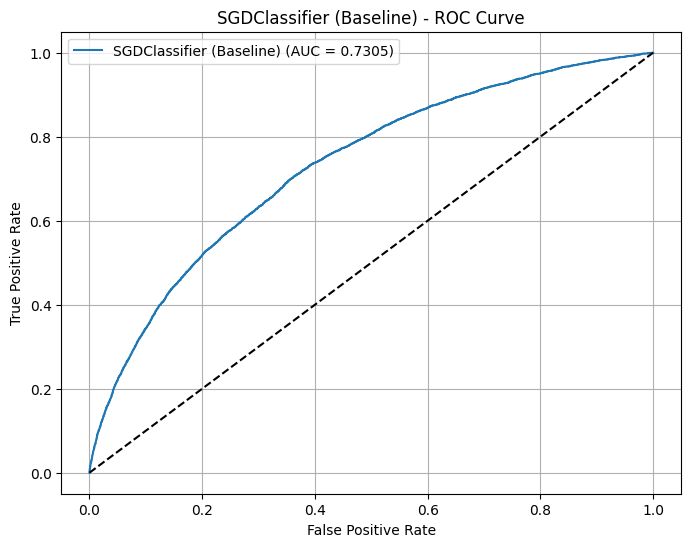


--- Optuna Optimization for SGDClassifier ---


[I 2025-04-14 15:03:13,095] Using an existing study with name 'sgd_optimization' instead of creating a new one.


Starting Optuna optimization for SGD with max 1 trials (early stopping enabled)...


[I 2025-04-14 15:03:31,065] Trial 52 finished with value: 0.7489305269099755 and parameters: {'alpha': 0.00017738209943052863, 'max_iter': 2498, 'loss': 'log_loss', 'penalty': 'l2', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.039367892748828875}. Best is trial 44 with value: 0.7490045565815603.


Optuna optimization completed in 0.30 minutes

Best Params (SGDClassifier): {'alpha': 7.263767660364737e-05, 'max_iter': 2525, 'loss': 'log_loss', 'penalty': 'l2', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.027675676168657827}
Best CV ROC AUC score: 0.7490

Fitting best SGD pipeline on full training data...

Evaluating tuned SGD model...
Optimal threshold based on Youden's J-Statistic (OOF): 0.5142

--- Evaluation Metrics for SGDClassifier (Optuna Tuned) ---
AUC ROC:        0.7527
Gini Coefficient: 0.5054
KS Statistic:   0.3766
Accuracy:       0.7061
Precision:      0.1666
Recall (TPR):   0.6600
F1-Score:       0.2661
Brier Score:    0.2020
Log Loss:       0.5903

Confusion Matrix:
[[40147 16390]
 [ 1688  3277]]


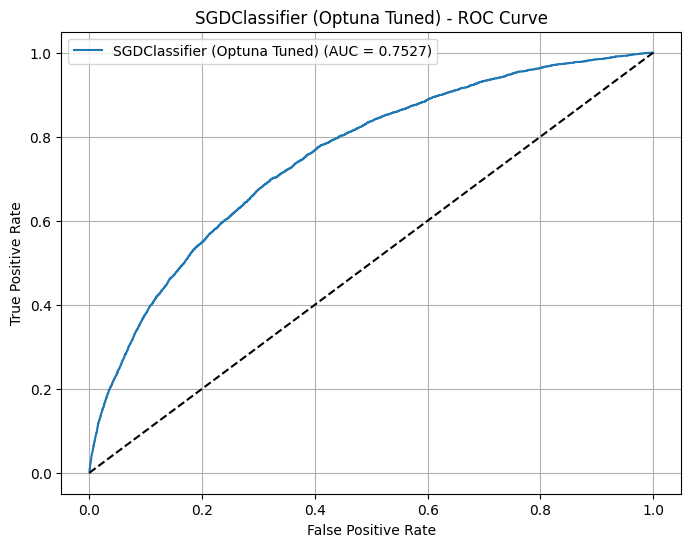


--- Top 50 Feature Importances ---
Sum of importances: 9.5211


,feature,importance
30,AMT_INCOME_TOTAL_MEAN_AGG_CODE_GENDER_FLAG_OWN...,0.94082
37,AMT_INCOME_TOTAL_MAX_AGG_CODE_GENDER_FLAG_OWN_...,0.60467
73,AGE_EMPLOYED_DIFF_MEAN_AGG_CODE_GENDER_FLAG_OW...,0.57265
95,AMT_INCOME_TOTAL_MIN_AGG_CODE_GENDER_FLAG_OWN_...,0.48365
0,WEIGHTED_EXT_SOURCE,0.32189
99,AMT_ANNUITY_MAX_AGG_CODE_GENDER_FLAG_OWN_CAR_F...,0.31326
35,ANNUITY_INCOME_RATIO_MAX_AGG_CODE_GENDER_FLAG_...,0.29541
5,EXT_SOURCE_1,0.26691
3,EXT_SOURCE_3,0.23637
15,B_B_CURRENT_CREDIT_DEBT_DIFF_MEAN_OVERALL,0.23517


In [9]:
# --- Model 1: SGDClassifier with Optuna Optimization ---
print("\n" + "="*60)
print("Model 2: SGDClassifier with Optuna Optimization")
print("="*60)

# Step 2.1: Baseline Pipeline (No change needed here)
print("\n--- Baseline SGDClassifier Training ---")
sgd_base_pipeline = ImblearnPipeline([
    # ('smote', SMOTE_VARIANT), # Keep SMOTE here
    ('scaler', StandardScaler()),
    ('model', SGDClassifier(loss='log_loss', penalty='l2', random_state=SEED,
                            class_weight='balanced', n_jobs=6, tol=1e-5))
])

sgd_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = sgd_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "SGDClassifier (Baseline)"))
plot_roc_curve(y_test, y_pred_proba_test_base, "SGDClassifier (Baseline)")

# Step 2.2: Optuna Hyperparameter Optimization
print("\n--- Optuna Optimization for SGDClassifier ---")

def objective_sgd(trial):
    # Define hyperparameters to tune
    alpha = trial.suggest_float('alpha', 1e-5, 1.0, log=True)
    max_iter = trial.suggest_int('max_iter', 500, 3000)
    loss = trial.suggest_categorical('loss', ['log_loss', 'modified_huber'])
    penalty = trial.suggest_categorical('penalty', ['l2', 'elasticnet'])
    l1_ratio = 0.15 # Default if penalty is elasticnet, fixed here for simplicity, could also tune
    class_weight_opt = trial.suggest_categorical('class_weight', ['balanced', None])
    learning_rate = trial.suggest_categorical('learning_rate', ['optimal', 'constant', 'invscaling', 'adaptive'])
    eta0 = 0.15 
    if learning_rate != 'optimal':
        eta0 = trial.suggest_float('eta0', 1e-4, 0.5, log=True)

    pipeline = ImblearnPipeline([
        ('scaler', StandardScaler()),
        ('model', SGDClassifier(
            loss=loss,
            penalty=penalty,
            alpha=alpha,
            l1_ratio=l1_ratio if penalty == 'elasticnet' else 0.15,
            max_iter=max_iter,
            class_weight=class_weight_opt,
            learning_rate=learning_rate,
            eta0=eta0,
            random_state=SEED,
            n_jobs=5,
            tol=1e-5
        ))
    ])

    try:
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=5)
        auc_score = np.mean(scores)
        # Handle potential errors during CV
        if np.isnan(auc_score):
            return 0.0 # Return low score if CV fails
        return auc_score
    except Exception as e:
        print(f"Trial failed with error: {e}")
        return 0.0 # Return low score for failed trials

# Create an Optuna study
study_sgd = optuna.create_study(direction='maximize',
                                study_name='sgd_optimization',
                                storage=f'sqlite:///{MODEL_OUTPUT_PATH}optuna_studies.db',
                                load_if_exists=True) 

print(f"Starting Optuna optimization for SGD with max {OPTUNA_N_TRIALS} trials (early stopping enabled)...")
start_time = time.time()
study_sgd.optimize(objective_sgd, n_trials=OPTUNA_N_TRIALS, n_jobs=1)
end_time = time.time()
print(f"Optuna optimization completed in {(end_time - start_time)/60:.2f} minutes")

# Get best parameters and build the final pipeline
best_params_sgd_raw = study_sgd.best_params
best_params_sgd = {f'model__{k}': v for k, v in best_params_sgd_raw.items()}
print(f"\nBest Params (SGDClassifier): {best_params_sgd_raw}")
print(f"Best CV ROC AUC score: {study_sgd.best_value:.4f}")

best_sgd_pipeline = ImblearnPipeline([
    ('scaler', StandardScaler()),
    ('model', SGDClassifier(random_state=SEED, n_jobs=8, tol=1e-5, class_weight='balanced'))
])
best_sgd_pipeline.set_params(**best_params_sgd)

# Fit the best pipeline on the full training data
print("\nFitting best SGD pipeline on full training data...")
best_sgd_pipeline.fit(X_train, y_train)

# Step 2.3: Optimal Threshold and Evaluation
print("\nEvaluating tuned SGD model...")
y_prob_oof_sgd = cross_val_predict(best_sgd_pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
optimal_threshold_sgd = find_optimal_threshold_j_statistic(y_train, y_prob_oof_sgd)

y_pred_proba_test_tuned = best_sgd_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_sgd).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "SGDClassifier (Optuna Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "SGDClassifier (Optuna Tuned)")

# Feature importance via coefficients
final_sgd_model = best_sgd_pipeline.named_steps['model']
if hasattr(final_sgd_model, 'coef_'):
    feature_importance_df = get_feature_importance(final_sgd_model, feature_names)

model_objects['SGD'] = best_sgd_pipeline # Store the best pipeline
feature_importance_df.to_csv(MODEL_OUTPUT_PATH + 'sgd_feature_importance.csv', index=False)

# 4. Model 2: XGBoost


Model 3: XGBoost with Optuna Optimization & GPU

--- Baseline XGBoost Training ---


[I 2025-04-14 15:04:07,282] Using an existing study with name 'xgb_optimization' instead of creating a new one.



--- Evaluation Metrics for XGBoost (Baseline) ---
AUC ROC:        0.7603
Gini Coefficient: 0.5206
KS Statistic:   0.3954
Accuracy:       0.7497
Precision:      0.1858
Recall (TPR):   0.6207
F1-Score:       0.2859
Brier Score:    0.1667
Log Loss:       0.5001

Confusion Matrix:
[[43027 13510]
 [ 1883  3082]]

--- Optuna Optimization for XGBoost ---
Starting Optuna optimization for XGBoost with max 1 trials (early stopping enabled)...


[I 2025-04-14 15:04:51,051] Trial 50 finished with value: 0.7587901654414037 and parameters: {'n_estimators': 914, 'max_depth': 5, 'learning_rate': 0.0786496153628248, 'subsample': 0.840513745060001, 'colsample_bytree': 0.6449266373382219, 'gamma': 0.07619983384034718, 'reg_alpha': 6.6140549600591636e-06, 'reg_lambda': 0.07755486643912782}. Best is trial 33 with value: 0.7689203951862111.


Optuna optimization completed in 0.73 minutes

Best Params (XGBoost): {'n_estimators': 901, 'max_depth': 3, 'learning_rate': 0.08002379691269995, 'subsample': 0.9673038013141566, 'colsample_bytree': 0.7756429826491325, 'gamma': 0.27575977990389733, 'reg_alpha': 0.06268047181720374, 'reg_lambda': 0.2645932654973002}
Best CV ROC AUC score: 0.7689

Fitting best XGBoost pipeline on full training data...

Evaluating tuned XGBoost model...
Optimal threshold based on Youden's J-Statistic (OOF): 0.0833

--- Evaluation Metrics for XGBoost (Optuna Tuned) ---
AUC ROC:        0.7736
Gini Coefficient: 0.5472
KS Statistic:   0.4120
Accuracy:       0.7175
Precision:      0.1782
Recall (TPR):   0.6918
F1-Score:       0.2834
Brier Score:    0.0666
Log Loss:       0.2409

Confusion Matrix:
[[40694 15843]
 [ 1530  3435]]


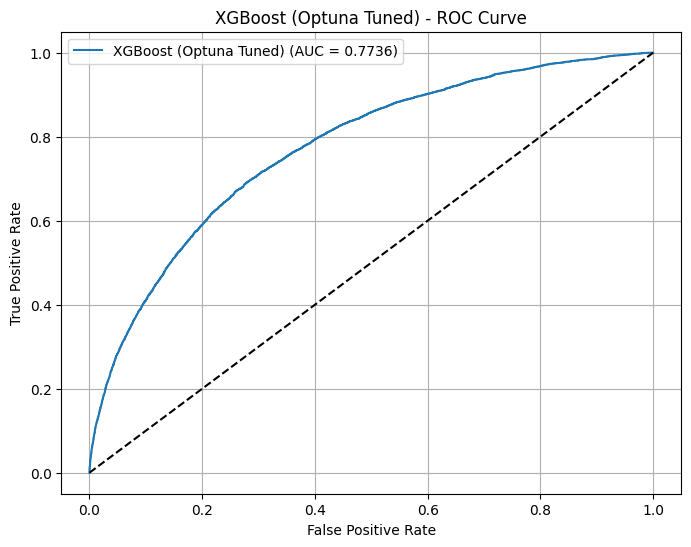


--- Top 50 Feature Importances ---
Sum of importances: 1.0000


,feature,importance
0,WEIGHTED_EXT_SOURCE,0.18156
1,EXT_SOURCE_MIN,0.05081
2,EXT_SOURCE_MAX,0.03563
99,AMT_ANNUITY_MAX_AGG_CODE_GENDER_FLAG_OWN_CAR_F...,0.02857
25,AGE_EMPLOYED_DIFF_MEAN_AGG_NAME_EDUCATION_TYPE...,0.02112
20,CREDIT_GOODS_RATIO,0.01944
35,ANNUITY_INCOME_RATIO_MAX_AGG_CODE_GENDER_FLAG_...,0.01895
95,AMT_INCOME_TOTAL_MIN_AGG_CODE_GENDER_FLAG_OWN_...,0.01787
15,B_B_CURRENT_CREDIT_DEBT_DIFF_MEAN_OVERALL,0.01637
101,FLAG_DOCUMENT_3,0.01625


In [10]:
# --- Model 2: XGBoost with Optuna Optimization & GPU ---
print("\n" + "="*60)
print("Model 3: XGBoost with Optuna Optimization & GPU")
print("="*60)

# Step 3.1: Baseline Pipeline (Add GPU option)
print("\n--- Baseline XGBoost Training ---")
xgb_base_pipeline = ImblearnPipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', scale_pos_weight=11.5,
                                use_label_encoder=False, random_state=SEED, n_jobs=6,
                                tree_method='gpu_hist' if device_name == 'cuda' else 'hist'
                               ))
])
xgb_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = xgb_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "XGBoost (Baseline)"))

# Step 3.2: Optuna Hyperparameter Optimization
print("\n--- Optuna Optimization for XGBoost ---")

def objective_xgb(trial):
    # Define hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'random_state': SEED,
        'n_jobs': 6,
        'scale_pos_weight' : 11.5,
        'tree_method': 'gpu_hist' if device_name == 'cuda' else 'hist' # Enable GPU
    }

    pipeline = ImblearnPipeline([
        ('scaler', StandardScaler()),
        ('model', xgb.XGBClassifier(**param))
    ])

    try:
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
        auc_score = np.mean(scores)
        if np.isnan(auc_score): return 0.0
        return auc_score
    except Exception as e:
        print(f"Trial failed with error: {e}")
        return 0.0

# Create and run study
study_xgb = optuna.create_study(direction='maximize',
                                study_name='xgb_optimization',
                                storage=f'sqlite:///{MODEL_OUTPUT_PATH}optuna_studies.db',
                                load_if_exists=True)

print(f"Starting Optuna optimization for XGBoost with max {OPTUNA_N_TRIALS} trials (early stopping enabled)...")
start_time = time.time()
study_xgb.optimize(objective_xgb, n_trials=OPTUNA_N_TRIALS, n_jobs=1)
end_time = time.time()
print(f"Optuna optimization completed in {(end_time - start_time)/60:.2f} minutes")

# Get best parameters and build final pipeline
best_params_xgb_raw = study_xgb.best_params
best_params_xgb = {f'model__{k}': v for k, v in best_params_xgb_raw.items()}
print(f"\nBest Params (XGBoost): {best_params_xgb_raw}")
print(f"Best CV ROC AUC score: {study_xgb.best_value:.4f}")

best_xgb_pipeline = ImblearnPipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
                                use_label_encoder=False, random_state=SEED, n_jobs=6,
                                tree_method='gpu_hist' if device_name == 'cuda' else 'hist'))
])
# Update only the tuned parameters
best_xgb_pipeline.set_params(**best_params_xgb)

print("\nFitting best XGBoost pipeline on full training data...")
best_xgb_pipeline.fit(X_train, y_train)

# Step 3.3: Optimal Threshold and Evaluation
print("\nEvaluating tuned XGBoost model...")
y_prob_oof_xgb = cross_val_predict(best_xgb_pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
optimal_threshold_xgb = find_optimal_threshold_j_statistic(y_train, y_prob_oof_xgb)

y_pred_proba_test_tuned = best_xgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_xgb).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "XGBoost (Optuna Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "XGBoost (Optuna Tuned)")
feature_df = get_feature_importance(best_xgb_pipeline.named_steps['model'], feature_names)
model_objects['XGB'] = best_xgb_pipeline
feature_df.to_csv(MODEL_OUTPUT_PATH + 'xgb_feature_importance.csv', index=False)

# 5. Model 3: LightGBM


Model 4: LightGBM with Optuna Optimization & GPU

--- Baseline LightGBM Training ---
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 18944
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 112
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics 770, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 108 dense feature groups (25.34 MB) transferred to GPU in 0.016136 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469

--- Evaluation Metrics for LightGBM (Baseline) ---
AUC ROC:        0.7739
Gini Coefficient: 0.5479
KS Statistic:   0.4079
Accuracy:       0.7093
Precision:      0.1742
Rec

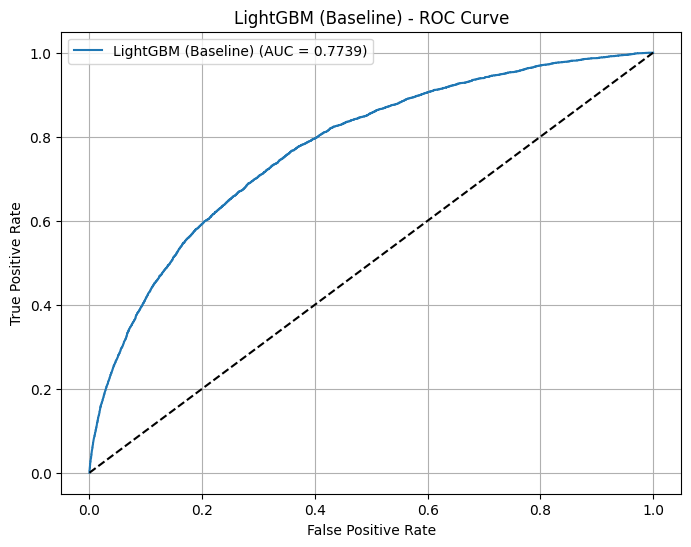


--- Top 50 Feature Importances ---
Sum of importances: 3000.0000


,feature,importance
6,CREDIT_ANNUITY_RATIO,295
0,WEIGHTED_EXT_SOURCE,109
16,DAYS_BIRTH,89
106,AMT_ANNUITY,85
20,CREDIT_GOODS_RATIO,65
10,DAYS_EMPLOYED,65
5,EXT_SOURCE_1,64
11,B_B_CURRENT_DEBT_TO_CREDIT_RATIO_MAX_OVERALL,63
4,EXT_SOURCE_2,58
1,EXT_SOURCE_MIN,57



--- Optuna Optimization for LightGBM ---


[I 2025-04-14 15:05:43,127] Using an existing study with name 'lgbm_optimization' instead of creating a new one.


EarlyStoppingCallback initialized: patience=50, min_improvement=0.001
Starting Optuna optimization for LightGBM with max 1 trials (early stopping enabled)...


[I 2025-04-14 15:07:02,423] Trial 50 finished with value: 0.7621090375114025 and parameters: {'n_estimators': 235, 'learning_rate': 0.01208425306437188, 'num_leaves': 55, 'max_depth': 9, 'subsample': 0.9836077035671471, 'colsample_bytree': 0.6213100549404831, 'reg_alpha': 0.005517654984599063, 'reg_lambda': 1.3909172718236847e-07}. Best is trial 12 with value: 0.770852763658996.


First trial, best_score initialized to 0.7621
Optuna optimization completed in 1.32 minutes

Best Params (LightGBM): {'n_estimators': 779, 'learning_rate': 0.010707823134853488, 'num_leaves': 53, 'max_depth': 10, 'subsample': 0.8863570533375423, 'colsample_bytree': 0.6644943517181735, 'reg_alpha': 4.332859137722658e-05, 'reg_lambda': 1.5698235438285013e-06}
Best CV ROC AUC score: 0.7709

Fitting best LightGBM pipeline on full training data...
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 18944
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 112
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics 770, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 108 dense feature groups (25.34 MB) transf

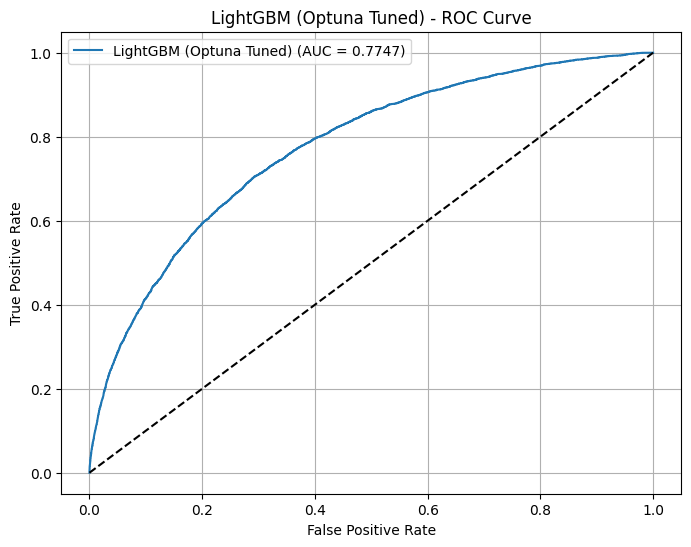


--- Top 50 Feature Importances ---
Sum of importances: 40508.0000


,feature,importance
6,CREDIT_ANNUITY_RATIO,2770
0,WEIGHTED_EXT_SOURCE,1137
20,CREDIT_GOODS_RATIO,1036
106,AMT_ANNUITY,942
16,DAYS_BIRTH,939
5,EXT_SOURCE_1,907
84,AGE_EMPLOYED_DIFF,893
11,B_B_CURRENT_DEBT_TO_CREDIT_RATIO_MAX_OVERALL,838
90,DAYS_ID_PUBLISH,775
1,EXT_SOURCE_MIN,760


In [11]:
# --- Model 3: LightGBM with Optuna Optimization & GPU ---
print("\n" + "="*60)
print("Model 4: LightGBM with Optuna Optimization & GPU")
print("="*60)

print("\n--- Baseline LightGBM Training ---")
lgb_base_pipeline = ImblearnPipeline([
    #('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', lgb.LGBMClassifier(objective='binary', metric='auc', random_state=SEED, n_jobs=6, scale_pos_weight=11.5,
                                 device='gpu' if device_name == 'cuda' else 'cpu' # Enable GPU if available
                                ))
])

lgb_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = lgb_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "LightGBM (Baseline)"))
plot_roc_curve(y_test, y_pred_proba_test_base, "LightGBM (Baseline)")
get_feature_importance(lgb_base_pipeline.named_steps['model'], feature_names)

print("\n--- Optuna Optimization for LightGBM ---")

def objective_lgbm(trial):
    # Define hyperparameters
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'random_state': SEED,
        'n_jobs': 5,
        'device': 'gpu' if device_name == 'cuda' else 'cpu', # Enable GPU
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'scale_pos_weight' : 11.5,
        # 'min_child_samples': trial.suggest_int('min_child_samples', 5, 100), # Optional: depends on dataset size
    }

    pipeline = ImblearnPipeline([
        #('smote', SMOTE_VARIANT),
        ('scaler', StandardScaler()),
        ('model', lgb.LGBMClassifier(**param))
    ])

    try:
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=5)
        auc_score = np.mean(scores)
        if np.isnan(auc_score): return 0.0
        return auc_score
    except Exception as e:
        # LightGBM can sometimes throw errors with certain parameter combos
        print(f"Trial failed with error: {e}")
        return 0.0

study_lgbm = optuna.create_study(direction='maximize',
                                study_name='lgbm_optimization',
                                storage=f'sqlite:///{MODEL_OUTPUT_PATH}optuna_studies.db',
                                load_if_exists=True)

early_stopping = EarlyStoppingCallback(patience=50, min_improvement=0.001)
timeout = TimeoutCallback(timeout=3600)  # 1 hour timeout

# Run optimization with callbacks
print(f"Starting Optuna optimization for LightGBM with max {OPTUNA_N_TRIALS} trials (early stopping enabled)...")
start_time = time.time()
study_lgbm.optimize(objective_lgbm, n_trials=OPTUNA_N_TRIALS, callbacks=[early_stopping, timeout], n_jobs=1)
end_time = time.time()
print(f"Optuna optimization completed in {(end_time - start_time)/60:.2f} minutes")

# Get best parameters and build final pipeline
best_params_lgbm_raw = study_lgbm.best_params
best_params_lgbm = {f'model__{k}': v for k, v in best_params_lgbm_raw.items()}
print(f"\nBest Params (LightGBM): {best_params_lgbm_raw}")
print(f"Best CV ROC AUC score: {study_lgbm.best_value:.4f}")

best_lgb_pipeline = ImblearnPipeline([
    #('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', lgb.LGBMClassifier(objective='binary', metric='auc', random_state=SEED, n_jobs=5,
                                 device='gpu' if device_name == 'cuda' else 'cpu'))
])
# Update only the tuned parameters
best_lgb_pipeline.set_params(**best_params_lgbm)

print("\nFitting best LightGBM pipeline on full training data...")
best_lgb_pipeline.fit(X_train, y_train)

print("\nEvaluating tuned LightGBM model...")
y_prob_oof_lgb = cross_val_predict(best_lgb_pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=4)[:, 1]
optimal_threshold_lgb = find_optimal_threshold_j_statistic(y_train, y_prob_oof_lgb)

y_pred_proba_test_tuned = best_lgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_lgb).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "LightGBM (Optuna Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "LightGBM (Optuna Tuned)")
feature_df = get_feature_importance(best_lgb_pipeline.named_steps['model'], feature_names)
model_objects['LGBM'] = best_lgb_pipeline 
feature_df.to_csv(MODEL_OUTPUT_PATH + 'lgbm_feature_importance.csv', index=False)

# 8. Model Evaluation

In [12]:
# --- Final Results Comparison ---
print("\n" + "="*60)
print("Overall Model Comparison")
print("="*60)

baseline_results_df = pd.DataFrame(baseline_results).set_index('Model')
tuned_results_df = pd.DataFrame(tuned_results).set_index('Model') # Now contains Optuna results

print("\n--- Baseline Model Performance (Test Set, Threshold=0.5 or Balanced Weight) ---")
display(baseline_results_df.sort_values('AUC', ascending=False))

print("\n--- Tuned Model Performance (Test Set, Optimal Threshold via Youden's J on OOF) ---")
display(tuned_results_df.sort_values('AUC', ascending=False))

# --- Save Results ---
baseline_results_df.to_csv(os.path.join(MODEL_OUTPUT_PATH, "baseline_model_results.csv"))
tuned_results_df.to_csv(os.path.join(MODEL_OUTPUT_PATH, "tuned_model_results_optuna.csv")) # Updated filename
print(f"\nResults saved to {MODEL_OUTPUT_PATH}")

# Optionally save the best models
model_save_path = os.path.join(MODEL_OUTPUT_PATH, 'best_models_optuna.pkl')
try:
    with open(model_save_path, 'wb') as f:
        pickle.dump(model_objects, f)
    print(f"Best model objects saved to {model_save_path}")
except Exception as e:
    print(f"Could not save models: {e}")

print("\nModeling complete.")


Overall Model Comparison

--- Baseline Model Performance (Test Set, Threshold=0.5 or Balanced Weight) ---


,AUC,Gini,KS,Accuracy,Precision,Recall,F1,Brier,LogLoss
Model,,,,,,,,,
LightGBM (Baseline),0.77394,0.54788,0.40792,0.70929,0.17415,0.69507,0.27852,0.18695,0.55067
XGBoost (Baseline),0.76032,0.52065,0.39537,0.74972,0.18575,0.62075,0.28594,0.16673,0.50006
SGDClassifier (Baseline),0.73054,0.46108,0.34270,0.65481,0.14808,0.68922,0.24378,0.22205,0.63958



--- Tuned Model Performance (Test Set, Optimal Threshold via Youden's J on OOF) ---


,AUC,Gini,KS,Accuracy,Precision,Recall,F1,Brier,LogLoss
Model,,,,,,,,,
LightGBM (Optuna Tuned),0.77471,0.54942,0.41254,0.69497,0.16990,0.71501,0.27456,0.06652,0.24065
XGBoost (Optuna Tuned),0.77361,0.54721,0.41204,0.71752,0.17818,0.69184,0.28338,0.06658,0.24092
SGDClassifier (Optuna Tuned),0.75271,0.50543,0.37662,0.70606,0.16662,0.66002,0.26608,0.20197,0.59029



Results saved to ./model_outputs/
Best model objects saved to ./model_outputs/best_models_optuna.pkl

Modeling complete.



Calculating SHAP values...


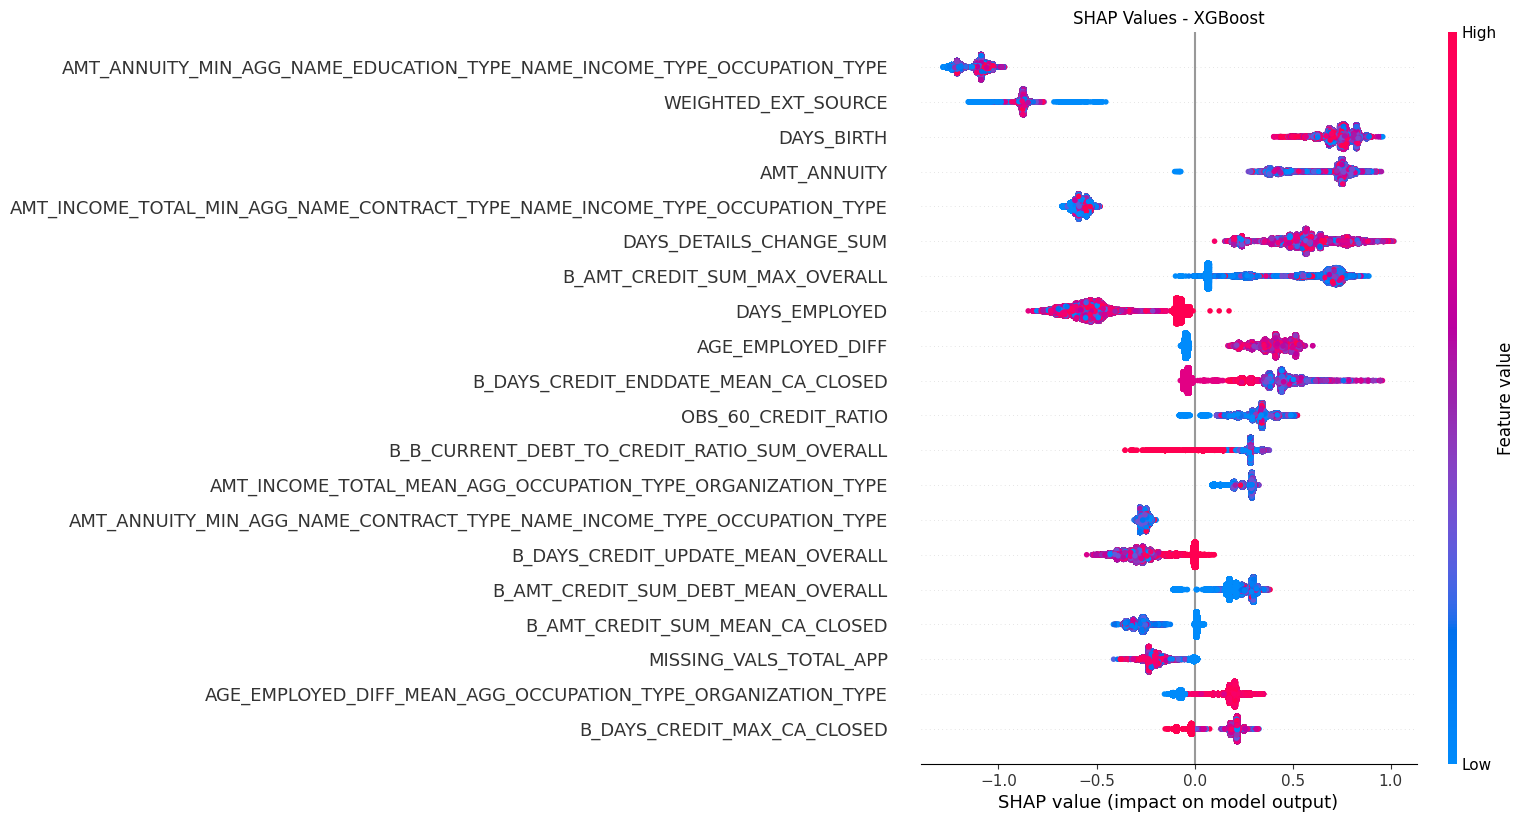

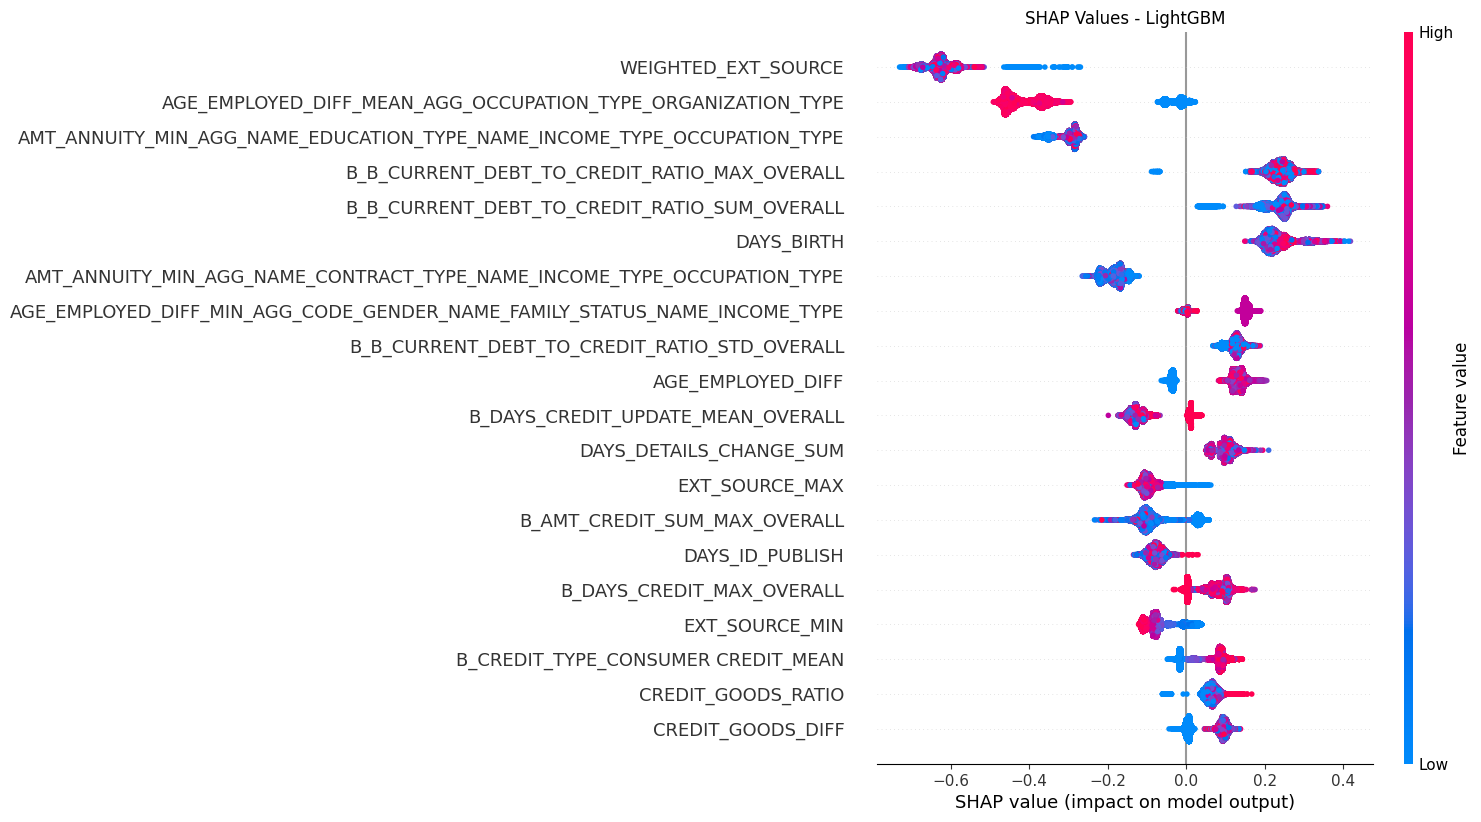

SHAP values calculated and saved.


In [16]:
# SHAP value for XGBoost and LightGBM
try:
    import shap
    print("\nCalculating SHAP values...")

    # For XGBoost
    explainer_xgb = shap.Explainer(best_xgb_pipeline.named_steps['model'])
    shap_values_xgb = explainer_xgb(X_train)

    # Plot summary plot for XGBoost with wider figure
    plt.figure(figsize=(30, 6)) # Increase figure width
    shap.summary_plot(shap_values_xgb, X_train, feature_names=feature_names, show=False)
    plt.title("SHAP Values - XGBoost")
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.savefig(os.path.join(MODEL_OUTPUT_PATH, 'shap_summary_xgb.png'))
    plt.show()
    plt.close()

    # For LightGBM
    explainer_lgb = shap.Explainer(best_lgb_pipeline.named_steps['model'])
    shap_values_lgb = explainer_lgb(X_train)

    # Plot summary plot for LightGBM with wider figure
    plt.figure(figsize=(30, 6)) # Increase figure width
    shap.summary_plot(shap_values_lgb, X_train, feature_names=feature_names, show=False)
    plt.title("SHAP Values - LightGBM")
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.savefig(os.path.join(MODEL_OUTPUT_PATH, 'shap_summary_lgb.png'))
    plt.show()
    plt.close()

    print("SHAP values calculated and saved.")
except ImportError as e:
    print(f"SHAP library not installed. Skipping SHAP value calculation. Error: {e}")
except Exception as e:
    print(f"An error occurred during SHAP calculation or plotting: {e}")